In [215]:
import numpy as np
import pandas as pd
import pickle
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm,gaussian_kde

In [216]:
data = pd.concat([pd.read_csv('./../data/%d.csv' % year) for year in range(2003,2017)])

In [217]:
rdata = pd.read_csv('./../data/round.csv')

In [218]:
rdata.head(2)

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694


In [219]:
data.head(2)

,#_of_Strokes,1st_Putt_Flag,Around_the_Green_Flag,Cat,Course_#,Course_Name,Difficulty_Start,Distance,Distance_from_hole,Distance_to_Hole_after_the_Shot,...,To_Location(Enhanced),To_Location(Laser),To_Location(Scorer),Tourn.#,Tournament_Name,Went_to_X,Went_to_Y,Went_to_Z,Yardage,Year
0,1,NaN,N,Tee Box,37,En-Joie GC,4.180556,8127,1138.807687,5562,...,Right Fairway,Fairway,NaN,290,B.C. Open,133.942909,443.689947,15.021,367,2003
1,1,NaN,Y,Fairway,37,En-Joie GC,2.950567,5979,463.466797,498,...,Left Rough,Primary Rough,NaN,290,B.C. Open,-32.345091,-25.977053,-0.430,367,2003


In [220]:
with open('./../PickleFiles/hole_tups.pkl','r') as pickleFile:
    tournorder = pickle.load(pickleFile)

In [221]:
df = pd.DataFrame(tournorder)
df.columns = ['Year','Permanent_Tournament_#','Round','Course_#','Hole']
round_tups = df[['Year','Course_#','Round']].drop_duplicates().values.tolist()
round_tups = [tuple(tup) for tup in round_tups]

In [222]:
round_tups[0:5]

[(2003, 656, 1), (2003, 656, 2), (2003, 656, 3), (2003, 656, 4), (2003, 6, 2)]

In [223]:
def make_specific_cats(distance,cat,par):
    if cat=='Tee Box':
        if par==3:
            return 'Tee-3'
        else:
            return 'Tee-45'
    elif cat=='Bunker' or cat=='Other':
        return cat
    elif cat=='Green' or cat=='Fringe':
        if distance<5:
            return 'Green-0'
        elif distance<10:
            return 'Green-5'
        elif distance<20:
            return 'Green-10'
        else:
            return 'Green-20'
    elif cat=='Fairway':
        if distance<300:
            return 'Fairway-0'
        elif distance<540:
            return 'Fairway-300'
        else:
            return 'Fairway-540'
    elif cat=='Primary Rough' or cat=='Intermediate Rough':
        if distance<90:
            return 'Rough-0'
        elif distance<375:
            return 'Rough-90'
        else:
            return 'Rough-375'

In [224]:
data.insert(len(data.columns),'Specific_Cat',
            [make_specific_cats(tup[0],tup[1],tup[2]) 
             for tup in data[['Distance_from_hole','Cat','Par_Value']].values.tolist()])

In [225]:
data.Specific_Cat.value_counts()

Green-0        2818013
Tee-45         2781546
Green-20       1358330
Fairway-300    1145044
Green-10       1035734
Green-5         874724
Tee-3           823746
Rough-375       695727
Fairway-540     641033
Fairway-0       602925
Bunker          503585
Rough-0         480052
Rough-90        262059
Other            68023
Name: Specific_Cat, dtype: int64

First a baseline of SG to field using simple average SG on different categories of shots.

In [246]:
course_profiles = defaultdict(lambda: defaultdict(list))
for year,course,round in round_tups:
    day = data[(data.Year==year) & (data['Course_#']==course) & (data.Round==round)]
    cat_aves = {}
    for cat,df in day.groupby('Specific_Cat'):
        player_map = df.groupby('Player_#').Strokes_Gained.mean().to_dict()
        cat_aves[cat] = np.array([player_map[player] if player in player_map else 0.0 
                                  for player in pd.unique(day['Player_#'])])
    rday = rdata[(rdata.Tournament_Year==year) & (rdata['Course_#']==course) & (rdata.Round_Number==round)]
    if len(rday)==0:
        continue
    ave_score = rday.groupby('Player_Number').Round_Score.mean().mean()
    score_map = rday.groupby('Player_Number').Round_Score.mean().to_dict()
    score_vec = np.array([score_map[player]-ave_score if player in score_map else np.nan 
                          for player in pd.unique(day['Player_#'])])
    for cat in cat_aves:
        cat_aves[cat] = cat_aves[cat][~np.isnan(score_vec)]
        course_profiles[course][cat].append(np.corrcoef(score_vec[~np.isnan(score_vec)],cat_aves[cat])[0,1])

In [228]:
for cat in pd.unique(data.Specific_Cat):
    print '**** %s ****' % cat
    for course in course_profiles:
        print course,len(course_profiles[course][cat]),np.mean(course_profiles[course][cat])

 **** Tee-45 ****
512 11 -0.255275931267
513 56 -0.272018579907
770 28 -0.300967887597
643 4 -0.374781980119
4 55 -0.287540845106
5 53 -0.23025901125
6 56 -0.284174992426
775 16 -0.279975939633
8 56 -0.286182418463
649 46 -0.161420154885
11 56 -0.239767197246
12 56 -0.222230739255
13 20 -0.297950841209
526 32 -0.300170619033
527 4 -0.323840725574
656 55 -0.197711579499
19 53 -0.24123228373
660 36 -0.310661194383
21 56 -0.267652304042
534 4 -0.313112313348
23 56 -0.249320810256
24 31 -0.295332625627
665 56 -0.233449389925
538 53 -0.291030239864
27 20 -0.279760638865
669 56 -0.300302385629
773 8 -0.35455507484
32 24 -0.289454548059
35 28 -0.317867970627
36 56 -0.395069873227
37 12 -0.427320609982
689 8 -0.309541374826
552 8 -0.342149241035
772 4 -0.29712820817
45 40 -0.286138238506
687 4 -0.300901119289
688 48 -0.259074731738
776 24 -0.229447573935
819 8 -0.285454192505
692 4 -0.206574904687
694 12 -0.345055512713
9 56 -0.278129948561
696 16 -0.258729212098
185 3 -0.0296682885945
698 56 

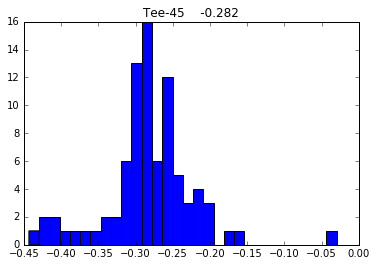

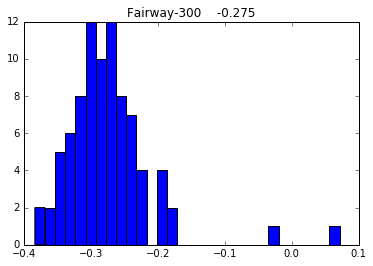

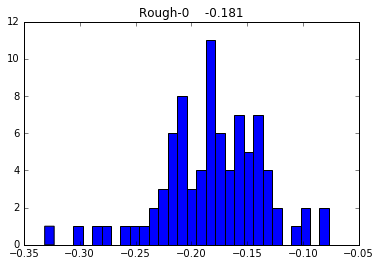

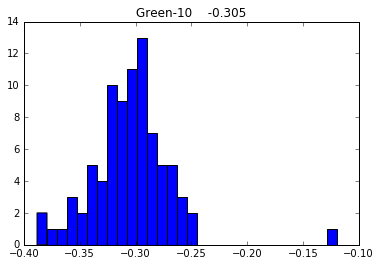

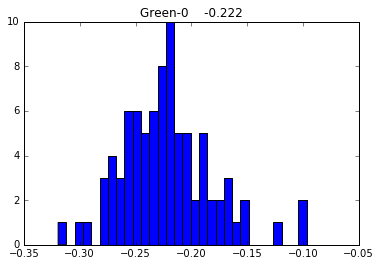

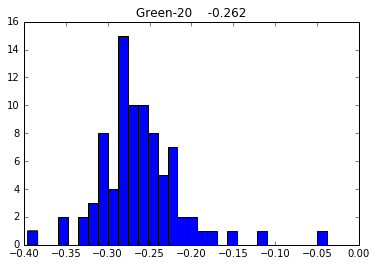

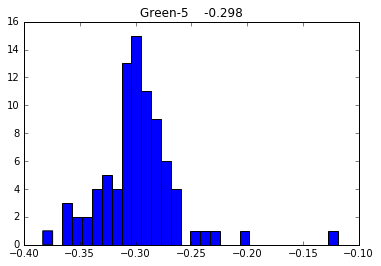

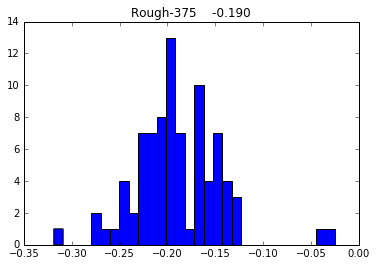

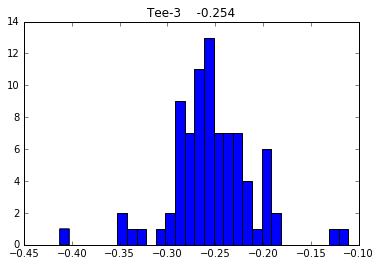

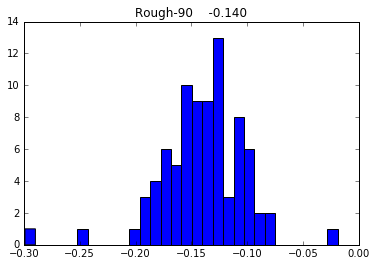

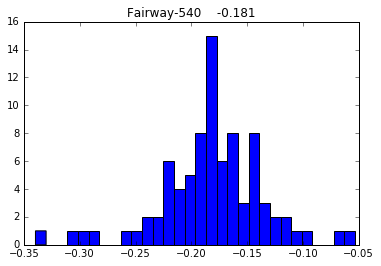

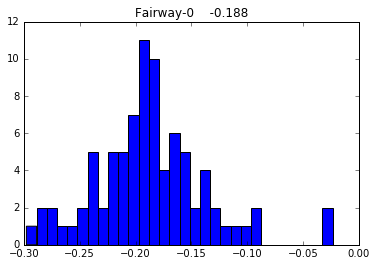

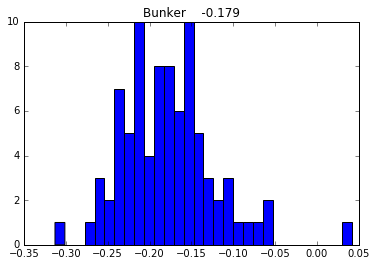

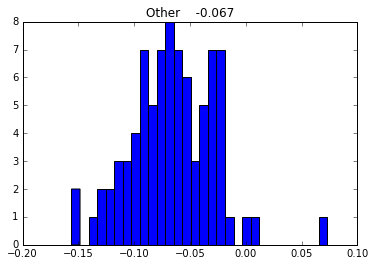

In [89]:
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    plt.hist(x,bins=30)
    plt.title(cat+'    %.3f' % np.mean(x))
    plt.show()

Set Priors

In [300]:
priors = defaultdict(None)
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    priors[cat] = (np.mean(x),np.std(x))

In [301]:
priors

defaultdict(None,
            {'Bunker': (-0.17868192820201398, 0.054583093382254082),
             'Fairway-0': (-0.1878019265399444, 0.050024037715439978),
             'Fairway-300': (-0.27510243101069115, 0.063826256700234424),
             'Fairway-540': (-0.1812335038661016, 0.046379149124701459),
             'Green-0': (-0.22243774662991139, 0.040959764404430811),
             'Green-10': (-0.30462705241605181, 0.03596912406023732),
             'Green-20': (-0.26198746827678382, 0.049154840357248382),
             'Green-5': (-0.29843758583081231, 0.035245620258273748),
             'Other': (-0.066538359253140292, 0.037729829283349843),
             'Rough-0': (-0.18099282335107106, 0.046414060071539032),
             'Rough-375': (-0.18993939363017701, 0.044368364992972704),
             'Rough-90': (-0.13986564123093118, 0.037930714775376781),
             'Tee-3': (-0.25363228069563298, 0.043798121504144097),
             'Tee-45': (-0.28220087042065922, 0.0602895334030488

In [302]:
for cat in pd.unique(data.Specific_Cat):
    mean,std = priors[cat][0],priors[cat][1]
    priors[cat] = [np.linspace(mean-3*std,mean+3*std,100),
                   norm.pdf(np.linspace(mean-3*std,mean+3*std,100),mean,std)/
                    norm.pdf(np.linspace(mean-3*std,mean+3*std,100),mean,std).sum()]

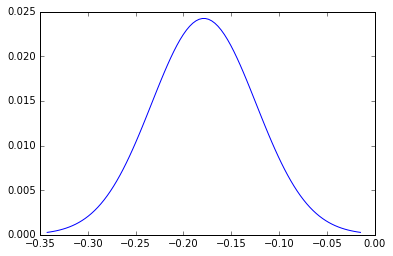

In [303]:
plt.plot(priors['Bunker'][0],priors['Bunker'][1]);

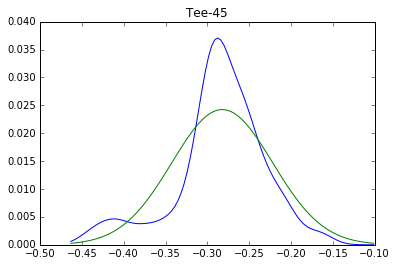

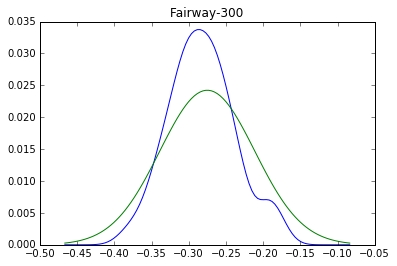

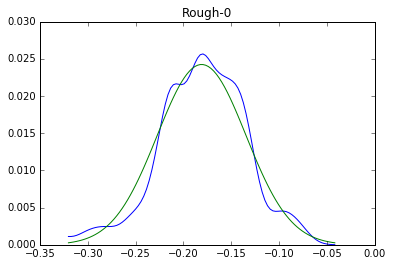

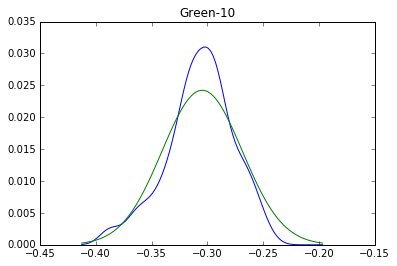

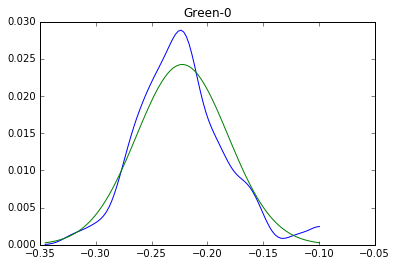

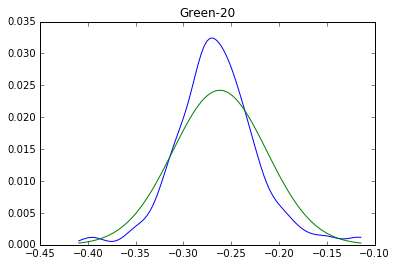

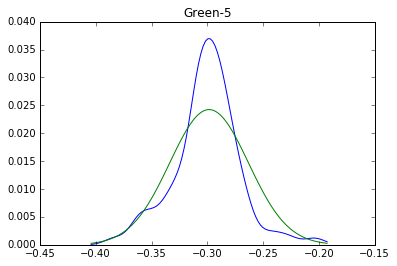

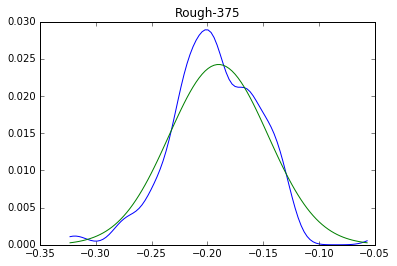

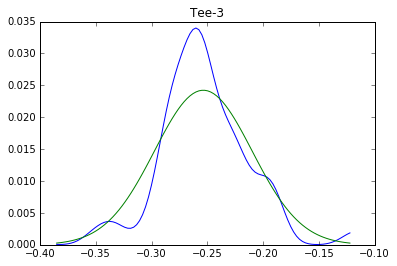

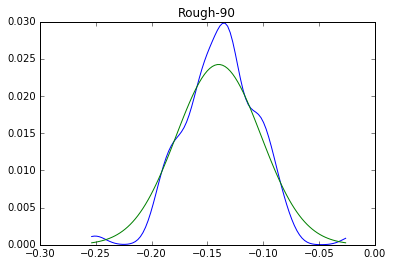

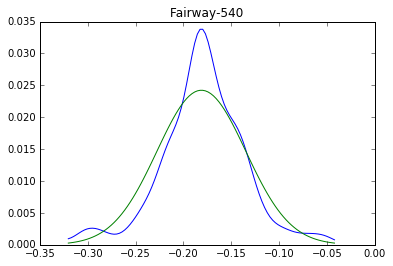

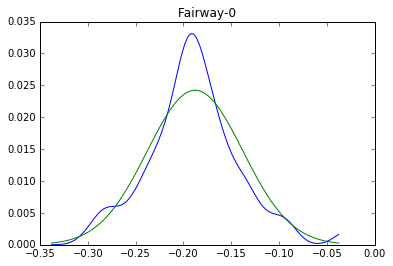

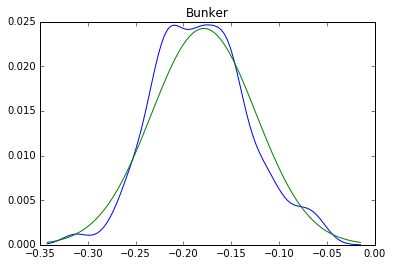

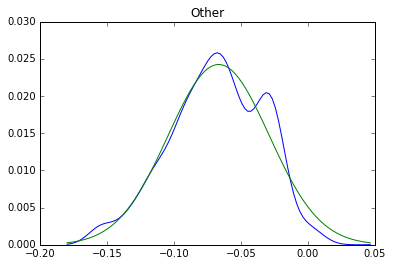

In [252]:
num_courses = len(pd.unique(data['Course_#']))
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    density = gaussian_kde(x)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(priors[cat][0],density(priors[cat][0])/density(priors[cat][0]).sum())
    plt.plot(priors[cat][0],priors[cat][1])
    plt.title(cat)
    plt.show()

Update based on data for each course, estimate posteriors

In [304]:
def update(x,p_x,r,n):
    se = 1.06/(n-3.0)**.5
    p_x *= norm.pdf(np.arctanh(x)-np.arctanh(r),0,se)
    p_x /= p_x.sum()
    return p_x

In [307]:
course_posteriors = {course:copy.deepcopy(priors) for course in pd.unique(data['Course_#'])}
for u,(year,course,round) in enumerate(round_tups):
    day = data[(data.Year==year) & (data['Course_#']==course) & (data.Round==round)]
    cat_aves = {}
    for cat,df in day.groupby('Specific_Cat'):
        player_map = df.groupby('Player_#').Strokes_Gained.mean().to_dict()
        cat_aves[cat] = np.array([player_map[player] if player in player_map else 0.0 
                                  for player in pd.unique(day['Player_#'])])
    rday = rdata[(rdata.Tournament_Year==year) & (rdata['Course_#']==course) & (rdata.Round_Number==round)]
    if len(rday)==0:
        continue
    ave_score = rday.groupby('Player_Number').Round_Score.mean().mean()
    score_map = rday.groupby('Player_Number').Round_Score.mean().to_dict()
    score_vec = np.array([score_map[player]-ave_score if player in score_map else np.nan 
                          for player in pd.unique(day['Player_#'])])
    for cat in cat_aves:
        cat_aves[cat] = cat_aves[cat][~np.isnan(score_vec)]
        course_posteriors[course][cat][1] = update(course_posteriors[course][cat][0],
                                                 course_posteriors[course][cat][1],
                                                 np.corrcoef(score_vec[~np.isnan(score_vec)],cat_aves[cat])[0,1],
                                                 cat_aves[cat].shape[0])    

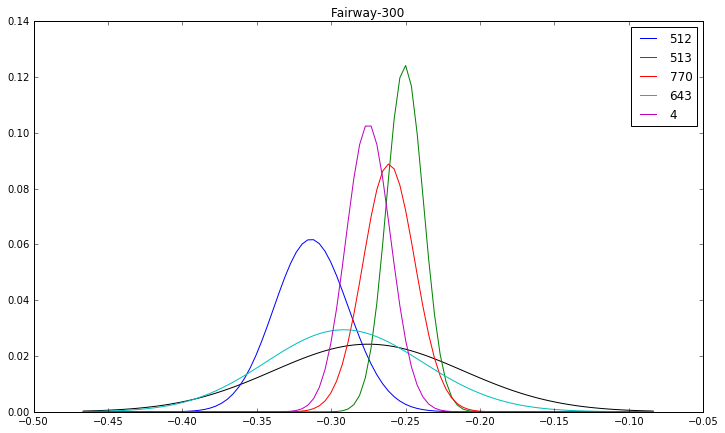

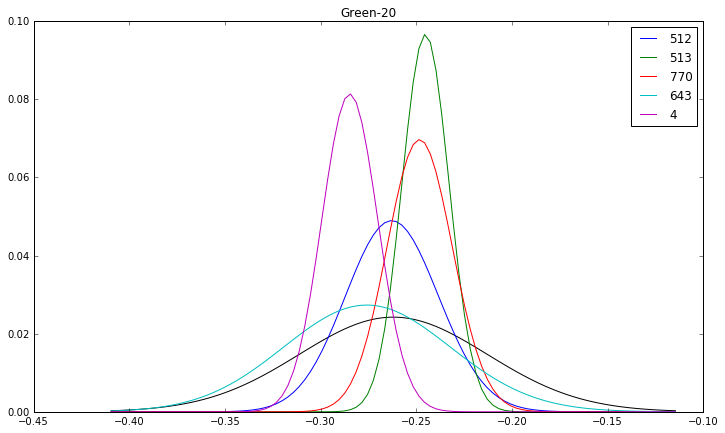

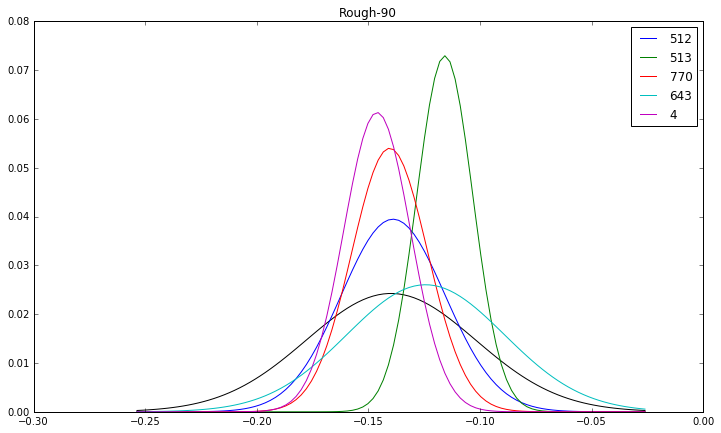

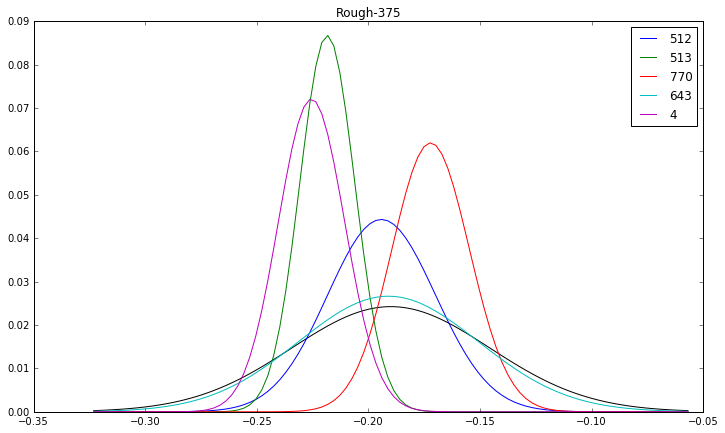

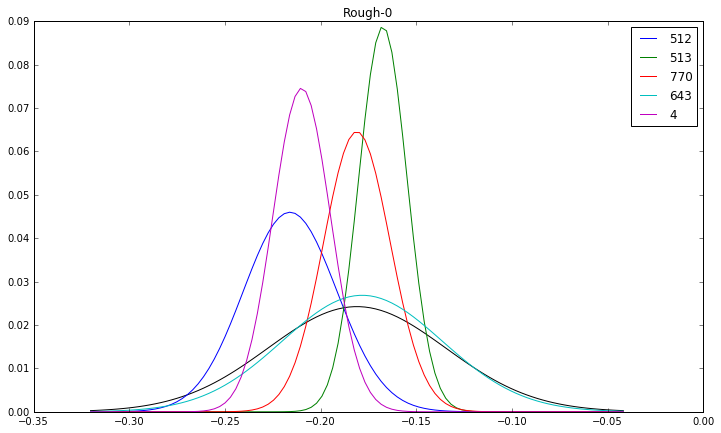

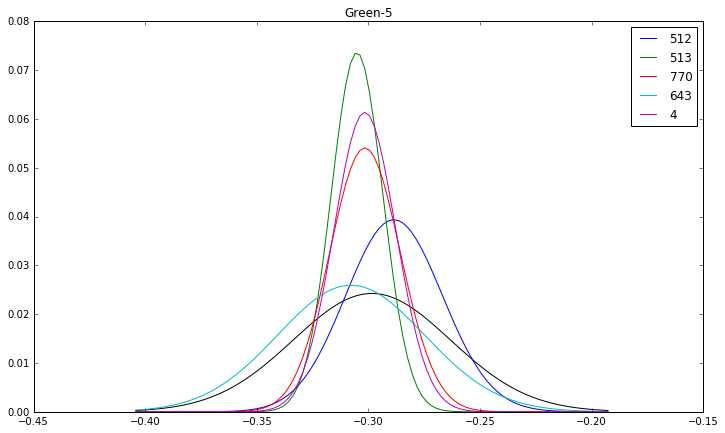

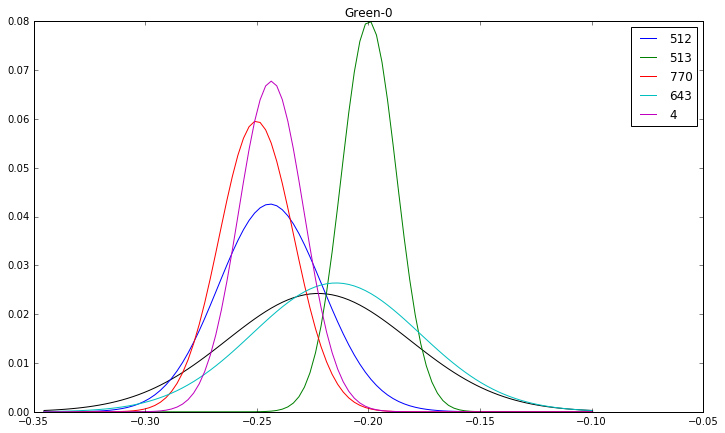

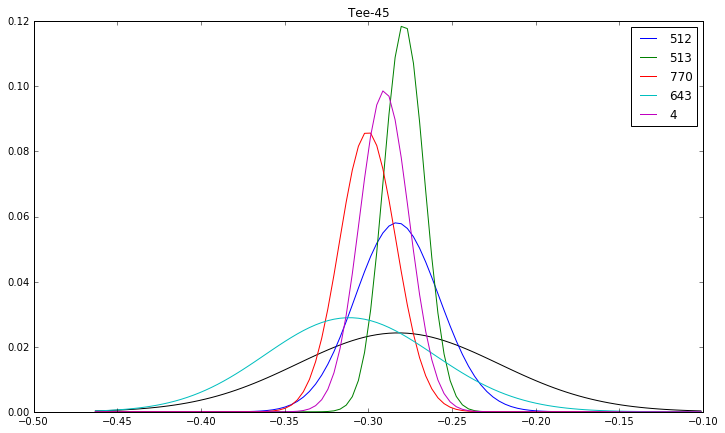

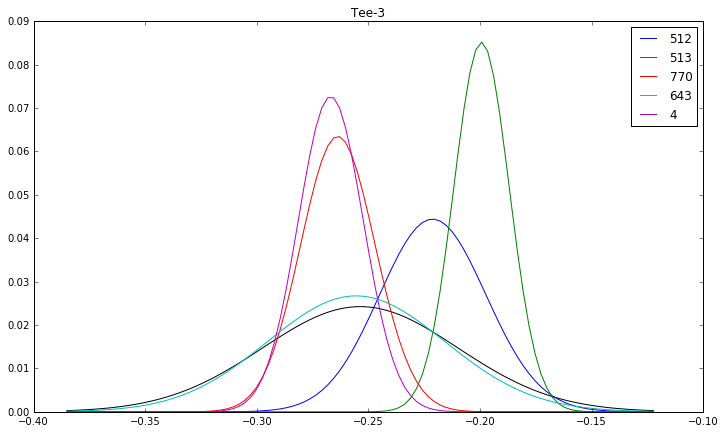

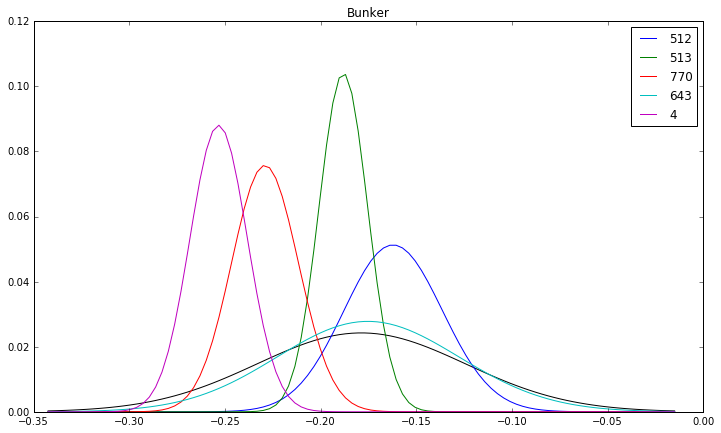

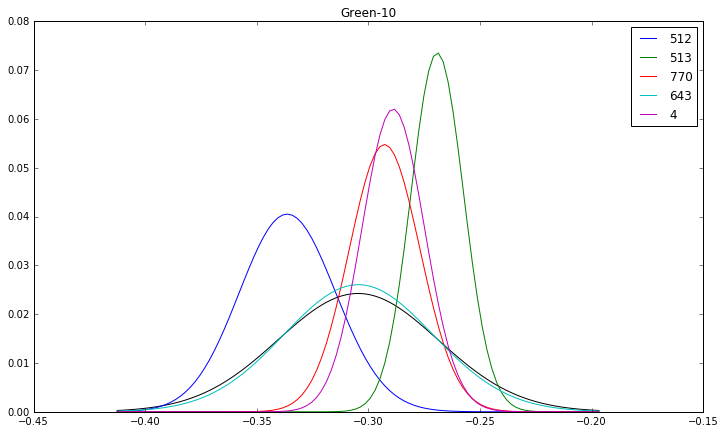

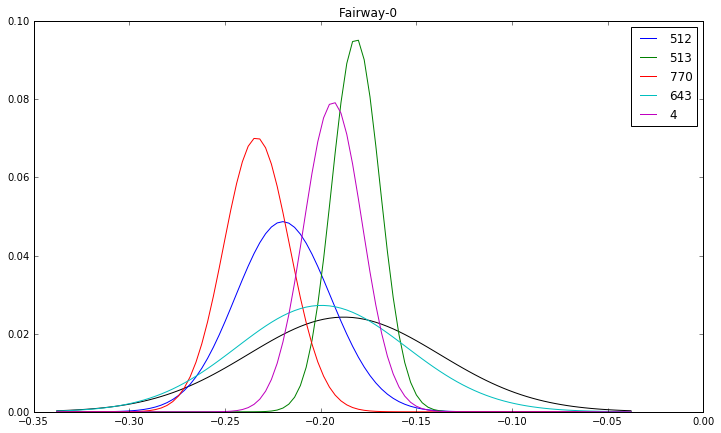

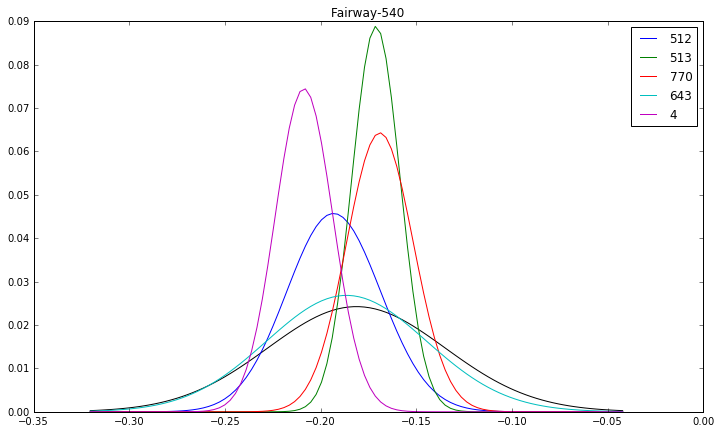

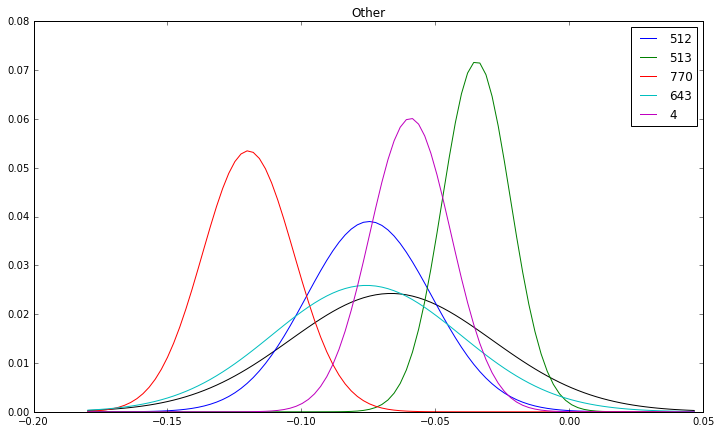

In [326]:
for cat in course_profiles[course_profiles.keys()[0]]:
    plt.figure(figsize=(12,7))
    plt.plot(priors[cat][0],priors[cat][1],c='black')
    for course in course_posteriors.keys()[:5]:
        plt.plot(course_posteriors[course][cat][0],course_posteriors[course][cat][1],label=str(course));
    plt.title(cat)
    plt.legend()
    plt.show();